In [41]:
import tensorflow
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pickle as pkl

# generate a random image

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
(1, 512)


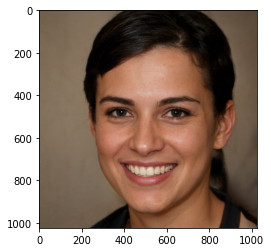

In [66]:
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
truncation_psi = 0.5


# load the networks
print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
if truncation_psi is not None:
    Gs_kwargs.truncation_psi = truncation_psi

# generate random z
seed = 6000
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
print(z.shape)

# generate image
w = {var: rnd.randn(*var.shape.as_list()) for var in noise_vars}
tflib.set_vars(w) # [height, width]
images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
# PIL.Image.fromarray(images[0], 'RGB').save(dnnlib.make_run_dir_path('seed%04d.png' % seed))
plt.imshow(images[0])
plt.show()

# recreate image from annotations

In [56]:
DATASET_DIR = '../data/annotation-dataset-stylegan2'
ANNOTATIONS_DIR = oj(DATASET_DIR, 'annotations')
DATA_DIR = oj(DATASET_DIR, 'data')

In [60]:
W = np.load(oj(DATA_DIR, 'W.npy'))
Z = np.load(oj(DATA_DIR, 'Z.npy'))
scores = np.load(oj(DATA_DIR, 'scores.npy'))

In [80]:
print(scores.shape, W.shape, Z.shape)

(5000, 7, 7) (5000, 512) (5000, 512)


In [81]:
z = Z[0].reshape(1, -1)

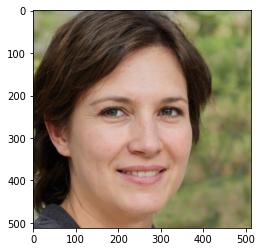

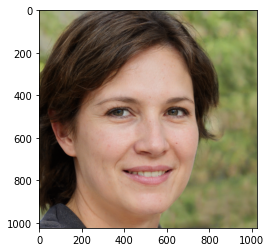

In [90]:
images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
im_gt = PIL.Image.open(oj(DATASET_DIR, 'images/0.jpg'))
plt.imshow(im_gt)
plt.show()
plt.imshow(images[0])
plt.show()